# Forecasting with Recurrent Neural Networks

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  %tensorflow_version 2.x
except:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
from matplotlib import style

import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [0]:
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

style.use('ggplot')

In [0]:
def plot_the_series(time_, series_, format_='-', start=0, end=None, label=None):
  plt.plot(time_[start:end], series_[start:end], format_, label=label)
  plt.xlabel("Time")
  plt.ylabel("Value")

  if label:
    plt.legend(fontsize=10)

In [0]:
def trend(time_, slope_=0):
  return time_ * slope_

def seasonal_pattern(season_time):
  seasonal_pattern_arr = np.where(season_time < 0.4, 
                                  np.cos(season_time * 2 * np.pi), 
                                  1 / np.exp(3 * season_time))
  return seasonal_pattern_arr

def seasonality(time_, period, amplitude=1, phase=0):
  season_time = ((time_ + phase) % period) / period
  seasonality_added = amplitude * seasonal_pattern(season_time)
  return seasonality_added

def white_noise(time_, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed=seed)
  noised_arr = rnd.randn(len(time_)) * noise_level
  return noised_arr

### Data Pipelines

In [0]:
def windowed_dataset(series_, window_size, batch_size=32, shuffle_buffer=1000):
  dataset = tf.data.Dataset.from_tensor_slices(tensors=series_)
  dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.shuffle(buffer_size=shuffle_buffer)
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size=batch_size).prefetch(1)
  return dataset

In [0]:
def model_forecast(model, series_, window_size, batch_size=32):
  dataset = tf.data.Dataset.from_tensor_slices(tensors=series_)
  dataset = dataset.window(size=window_size, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size))
  dataset = dataset.batch(batch_size=batch_size).prefetch(1)

  forecasts = model.predict(dataset)
  return forecasts

### Data

In [0]:
amplitude = 40
baseline = 10
slope_ = 0.05

time_ = np.arange(4 * 365 + 1)
series_ = baseline + trend(time_=time_, slope_=slope_) + seasonality(time_=time_, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time_=time_, noise_level=noise_level, seed=42)

series_ += noise

In [10]:
print(time_)
print(series_)

[   0    1    2 ... 1458 1459 1460]
[ 52.48357077  49.35275206  53.31473872 ...  91.37325376  88.32382529
 122.30772008]


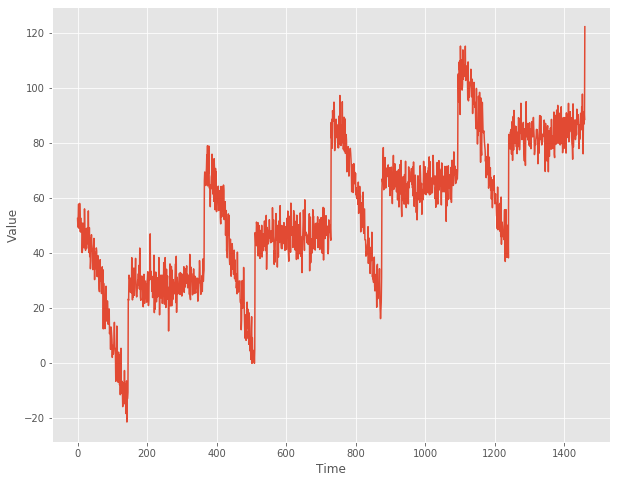

In [11]:
plt.figure(figsize=(10, 8))

plot_the_series(time_=time_, series_=series_)
plt.show()

### Training and Validation Splits

In [12]:
split_time = 1000

time_train = time_[:split_time]
x_train = series_[:split_time]

time_valid = time_[split_time:]
x_valid = series_[split_time:]

print("Number of observations in training set   : {}".format(len(x_train)))
print("Number of observations in validation set : {}".format(len(x_valid)))

Number of observations in training set   : 1000
Number of observations in validation set : 461


### Simple RNN Forecasting (Sequence-to-Vector RNN)

In [13]:
tensor_1 = tf.Variable([[[1, 2, 3, 4, 5], 
                         [6, 7, 8, 9, 10], 
                         [11, 12, 13, 14, 15]], 
                        [[1, 2, 3, 4, 5], 
                         [6, 7, 8, 9, 10], 
                         [11, 12, 13, 14, 15]]])
print(tensor_1.numpy())
print(tensor_1.shape)

[[[ 1  2  3  4  5]
  [ 6  7  8  9 10]
  [11 12 13 14 15]]

 [[ 1  2  3  4  5]
  [ 6  7  8  9 10]
  [11 12 13 14 15]]]
(2, 3, 5)


In [14]:
print(tf.shape(tf.expand_dims(input=tensor_1, axis=0)))
print(tf.shape(tf.expand_dims(input=tensor_1, axis=1)))
print(tf.shape(tf.expand_dims(input=tensor_1, axis=2)))
print(tf.shape(tf.expand_dims(input=tensor_1, axis=3)))

print(tf.shape(tf.expand_dims(input=tensor_1, axis=-1)))
print(tf.shape(tf.expand_dims(input=tensor_1, axis=-2)))
print(tf.shape(tf.expand_dims(input=tensor_1, axis=-3)))
print(tf.shape(tf.expand_dims(input=tensor_1, axis=-4)))

tf.Tensor([1 2 3 5], shape=(4,), dtype=int32)
tf.Tensor([2 1 3 5], shape=(4,), dtype=int32)
tf.Tensor([2 3 1 5], shape=(4,), dtype=int32)
tf.Tensor([2 3 5 1], shape=(4,), dtype=int32)
tf.Tensor([2 3 5 1], shape=(4,), dtype=int32)
tf.Tensor([2 3 1 5], shape=(4,), dtype=int32)
tf.Tensor([2 1 3 5], shape=(4,), dtype=int32)
tf.Tensor([1 2 3 5], shape=(4,), dtype=int32)


In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed=42)
np.random.seed(seed=42)

In [0]:
window_size = 30

training_set = windowed_dataset(series_=x_train, 
                                window_size=window_size, 
                                batch_size=128)

In [0]:
model_1 = tf.keras.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(input=x, axis=-1), 
                         input_shape=[None]), 
  tf.keras.layers.SimpleRNN(units=100, return_sequences=True), 
  tf.keras.layers.SimpleRNN(units=100), 
  tf.keras.layers.Dense(units=1), 
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

model_1.compile(optimizer=optimizer, 
                loss=tf.keras.losses.Huber(), 
                metrics=['mae'])

In [19]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 100)         10200     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model_1.fit(training_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 387ms/step - loss: 49.5423 - mae: 50.8965
Epoch 2/100
8/8 [==============================] - 1s 66ms/step - loss: 22.4395 - mae: 23.2030
Epoch 3/100
8/8 [==============================] - 1s 66ms/step - loss: 18.4148 - mae: 19.5125
Epoch 4/100
8/8 [==============================] - 1s 69ms/step - loss: 16.8015 - mae: 17.3120
Epoch 5/100
8/8 [==============================] - 0s 60ms/step - loss: 15.7448 - mae: 16.1971
Epoch 6/100
8/8 [==============================] - 1s 65ms/step - loss: 14.9736 - mae: 15.5585
Epoch 7/100
8/8 [==============================] - 1s 64ms/step - loss: 14.3579 - mae: 14.9520
Epoch 8/100
8/8 [==============================] - 1s 65ms/step - loss: 14.3614 - mae: 14.6318
Epoch 9/100
8/8 [==============================] - 1s 68ms/step - loss: 14.2957 - mae: 14.4190
Epoch 10/100
8/8 [==============================] - 0s 62ms/step - loss: 13.7645 - mae: 14.0410
Epoch 11/100
8/8 [==============================

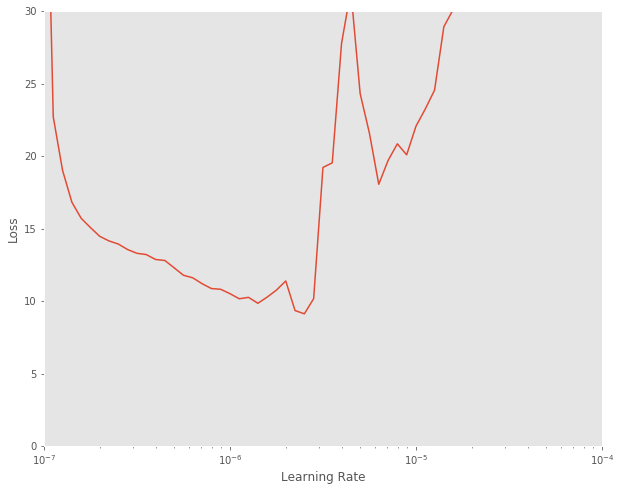

In [21]:
plt.figure(figsize=(10, 8))

plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-7, 1e-4, 0, 30])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.grid(False)
plt.show()

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed=42)
np.random.seed(seed=42)

In [0]:
window_size = 30

training_set = windowed_dataset(series_=x_train, window_size=window_size, batch_size=128)
validation_set = windowed_dataset(series_=x_valid, window_size=window_size, batch_size=128)

In [0]:
model_1 = tf.keras.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(input=x, axis=-1), 
                         input_shape=[None]), 
  tf.keras.layers.SimpleRNN(units=100, return_sequences=True), 
  tf.keras.layers.SimpleRNN(units=100), 
  tf.keras.layers.Dense(units=1), 
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.5e-6, momentum=0.9)

model_1.compile(optimizer=optimizer, 
                loss=tf.keras.losses.Huber(), 
                metrics=['mae'])

In [26]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 100)         10200     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_model_checkpoint.h5", save_best_only=True)

In [29]:
model_1.fit(training_set, 
            epochs=500, 
            validation_data=validation_set, 
            callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 1s 131ms/step - loss: 36.5513 - mae: 37.3106 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
8/8 [==============================] - 1s 76ms/step - loss: 24.1428 - mae: 24.0714 - val_loss: 12.5796 - val_mae: 13.0818
Epoch 3/500
8/8 [==============================] - 1s 82ms/step - loss: 17.0090 - mae: 17.6511 - val_loss: 22.0115 - val_mae: 22.3449
Epoch 4/500
8/8 [==============================] - 1s 86ms/step - loss: 14.3111 - mae: 14.3758 - val_loss: 9.9837 - val_mae: 10.6565
Epoch 5/500
8/8 [==============================] - 1s 80ms/step - loss: 11.7590 - mae: 12.0649 - val_loss: 11.4466 - val_mae: 12.0479
Epoch 6/500
8/8 [==============================] - 1s 85ms/step - loss: 10.8828 - mae: 11.4646 - val_loss: 8.4372 - val_mae: 8.9582
Epoch 7/500
8/8 [==============================] - 1s 82ms/step - loss: 10.4378 - mae: 10.4364 - val_loss: 7.8492 - val_mae: 8.3868
Epoch 8/500
8/8 [==============================] - 1s 83ms/s

In [0]:
model_1 = tf.keras.models.load_model(filepath="./best_model_checkpoint.h5")

In [31]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 100)         10200     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


In [0]:
seq_vec_rnn_forecasts = model_forecast(model=model_1, series_=series_[split_time-window_size:-1], window_size=window_size)

In [33]:
print(seq_vec_rnn_forecasts)
print(seq_vec_rnn_forecasts.shape)

[[68.2901  ]
 [69.842224]
 [71.788445]
 [70.43196 ]
 [67.1845  ]
 [67.884766]
 [68.943184]
 [70.52155 ]
 [70.012924]
 [70.71262 ]
 [68.46946 ]
 [70.581345]
 [69.43479 ]
 [72.71373 ]
 [69.37139 ]
 [71.61883 ]
 [69.875565]
 [68.183876]
 [66.75476 ]
 [65.614044]
 [67.48649 ]
 [68.609276]
 [67.29375 ]
 [66.57978 ]
 [70.8416  ]
 [73.41817 ]
 [72.48993 ]
 [70.2058  ]
 [68.77832 ]
 [69.87698 ]
 [67.57268 ]
 [66.674194]
 [62.910973]
 [65.63136 ]
 [67.77064 ]
 [67.38687 ]
 [70.08341 ]
 [66.49745 ]
 [64.4552  ]
 [65.55533 ]
 [68.650375]
 [72.18468 ]
 [69.900475]
 [70.54993 ]
 [68.878716]
 [69.34235 ]
 [70.27647 ]
 [70.33423 ]
 [66.64031 ]
 [69.605896]
 [71.16235 ]
 [69.645996]
 [69.90261 ]
 [69.11222 ]
 [69.62813 ]
 [68.69091 ]
 [66.87892 ]
 [66.4724  ]
 [69.84923 ]
 [70.91749 ]
 [69.03232 ]
 [69.75916 ]
 [63.495964]
 [67.69483 ]
 [64.06902 ]
 [65.65975 ]
 [63.952385]
 [63.296432]
 [67.15971 ]
 [67.37909 ]
 [69.0674  ]
 [67.97773 ]
 [69.647224]
 [69.49102 ]
 [67.13351 ]
 [69.13522 ]
 [67.81072 ]

In [0]:
seq_vec_rnn_forecasts_1D = seq_vec_rnn_forecasts[:, 0]

In [35]:
print(seq_vec_rnn_forecasts_1D)
print(seq_vec_rnn_forecasts_1D.shape)

[68.2901   69.842224 71.788445 70.43196  67.1845   67.884766 68.943184
 70.52155  70.012924 70.71262  68.46946  70.581345 69.43479  72.71373
 69.37139  71.61883  69.875565 68.183876 66.75476  65.614044 67.48649
 68.609276 67.29375  66.57978  70.8416   73.41817  72.48993  70.2058
 68.77832  69.87698  67.57268  66.674194 62.910973 65.63136  67.77064
 67.38687  70.08341  66.49745  64.4552   65.55533  68.650375 72.18468
 69.900475 70.54993  68.878716 69.34235  70.27647  70.33423  66.64031
 69.605896 71.16235  69.645996 69.90261  69.11222  69.62813  68.69091
 66.87892  66.4724   69.84923  70.91749  69.03232  69.75916  63.495964
 67.69483  64.06902  65.65975  63.952385 63.296432 67.15971  67.37909
 69.0674   67.97773  69.647224 69.49102  67.13351  69.13522  67.81072
 66.0307   65.555756 69.09549  71.52852  70.48431  68.55137  67.30786
 72.564896 72.58142  71.94308  72.05426  71.58137  70.71583  69.503815
 68.938896 69.01452  70.83212  70.17096  71.209755 81.38602  88.46611
 88.6479   91.9286

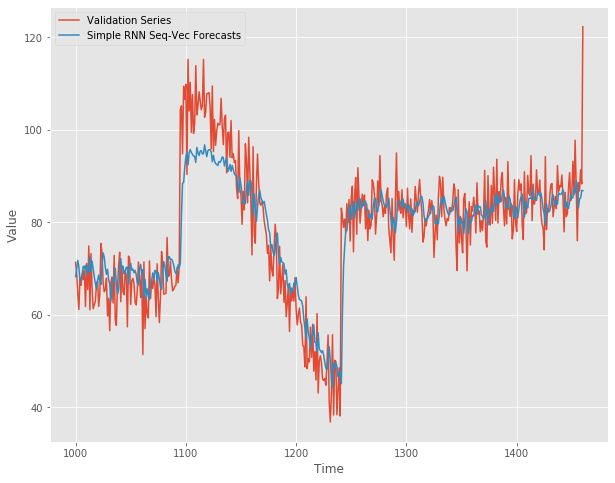

In [36]:
plt.figure(figsize=(10, 8))

plot_the_series(time_=time_valid, series_=x_valid, label="Validation Series")
plot_the_series(time_=time_valid, series_=seq_vec_rnn_forecasts_1D, label="Simple RNN Seq-Vec Forecasts")
plt.show()

In [37]:
seq_vec_rnn_forecasts_mae = tf.keras.metrics.mean_absolute_error(y_true=x_valid, y_pred=seq_vec_rnn_forecasts_1D).numpy()
seq_vec_rnn_forecasts_mae

5.4374638

### Simple RNN Forecasting (Sequence-to-Sequence RNN)

In [0]:
def seq2seq_windowed_dataset(series_, window_size, batch_size=32, shuffle_buffer=1000):
  series_ = tf.expand_dims(input=series_, axis=-1)

  dataset = tf.data.Dataset.from_tensor_slices(tensors=series_)
  dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.shuffle(buffer_size=shuffle_buffer)
  dataset = dataset.map(lambda window: (window[:-1], window[1:]))
  dataset = dataset.batch(batch_size=batch_size).prefetch(1)
  return dataset

In [39]:
for feature, label in seq2seq_windowed_dataset(series_=tf.range(10), window_size=3, batch_size=1).take(1):
  break

print(feature.numpy())
print(label.numpy())

print(feature.shape)
print(label.shape)

[[[1]
  [2]
  [3]]]
[[[2]
  [3]
  [4]]]
(1, 3, 1)
(1, 3, 1)


In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed=42)
np.random.seed(seed=42)

In [0]:
window_size = 30

training_set = seq2seq_windowed_dataset(series_=x_train, window_size=window_size, batch_size=128)

In [0]:
model_1 = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(units=100, return_sequences=True, input_shape=[None, 1]), 
  tf.keras.layers.SimpleRNN(units=100, return_sequences=True), 
  tf.keras.layers.Dense(units=1), 
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

model_1.compile(optimizer=optimizer, 
                loss=tf.keras.losses.Huber(), 
                metrics=['mae'])

In [44]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 100)         10200     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 100)         20100     
_________________________________________________________________
dense (Dense)                (None, None, 1)           101       
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


In [45]:
history = model_1.fit(training_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 297ms/step - loss: 51.7033 - mae: 53.0832
Epoch 2/100
8/8 [==============================] - 1s 70ms/step - loss: 25.2292 - mae: 25.9613
Epoch 3/100
8/8 [==============================] - 1s 70ms/step - loss: 23.1567 - mae: 23.7153
Epoch 4/100
8/8 [==============================] - 1s 72ms/step - loss: 21.1218 - mae: 21.3966
Epoch 5/100
8/8 [==============================] - 1s 68ms/step - loss: 19.5880 - mae: 19.9318
Epoch 6/100
8/8 [==============================] - 1s 65ms/step - loss: 18.7186 - mae: 19.1986
Epoch 7/100
8/8 [==============================] - 1s 67ms/step - loss: 18.1751 - mae: 18.6635
Epoch 8/100
8/8 [==============================] - 1s 64ms/step - loss: 17.9083 - mae: 18.2660
Epoch 9/100
8/8 [==============================] - 1s 67ms/step - loss: 17.5421 - mae: 17.9216
Epoch 10/100
8/8 [==============================] - 1s 65ms/step - loss: 17.3067 - mae: 17.5786
Epoch 11/100
8/8 [==============================

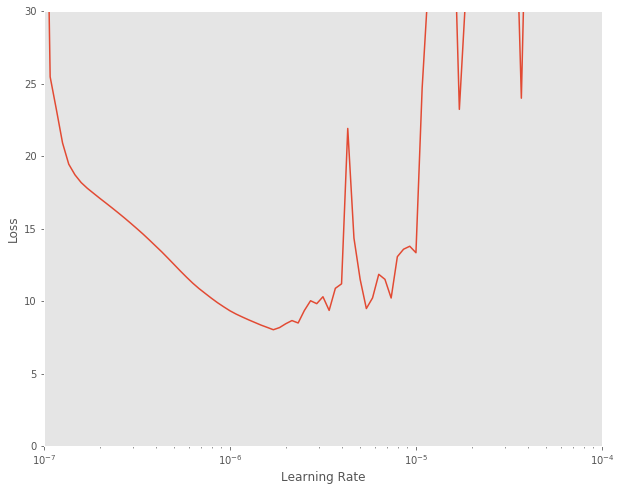

In [46]:
plt.figure(figsize=(10, 8))

plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-7, 1e-4, 0, 30])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.grid(False)
plt.show()

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed=42)
np.random.seed(seed=42)

In [0]:
window_size = 30

training_set = seq2seq_windowed_dataset(series_=x_train, window_size=window_size, batch_size=128)
validation_set = seq2seq_windowed_dataset(series_=x_valid, window_size=window_size, batch_size=128)

In [0]:
model_1 = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(units=100, return_sequences=True, input_shape=[None, 1]), 
  tf.keras.layers.SimpleRNN(units=100, return_sequences=True), 
  tf.keras.layers.Dense(units=1), 
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)

model_1.compile(optimizer=optimizer, 
                loss=tf.keras.losses.Huber(), 
                metrics=['mae'])

In [51]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 100)         10200     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 100)         20100     
_________________________________________________________________
dense (Dense)                (None, None, 1)           101       
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [53]:
model_1.fit(training_set, 
            epochs=500, 
            validation_data=validation_set, 
            callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 3s 350ms/step - loss: 55.8598 - mae: 56.2826 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
8/8 [==============================] - 1s 84ms/step - loss: 33.6746 - mae: 35.1114 - val_loss: 17.4471 - val_mae: 18.0774
Epoch 3/500
8/8 [==============================] - 1s 84ms/step - loss: 29.5658 - mae: 28.6514 - val_loss: 35.8525 - val_mae: 36.0964
Epoch 4/500
8/8 [==============================] - 1s 77ms/step - loss: 21.7688 - mae: 21.6919 - val_loss: 27.8288 - val_mae: 28.4824
Epoch 5/500
8/8 [==============================] - 1s 89ms/step - loss: 18.0302 - mae: 18.5032 - val_loss: 17.8702 - val_mae: 18.4260
Epoch 6/500
8/8 [==============================] - 1s 80ms/step - loss: 15.8201 - mae: 15.8192 - val_loss: 10.6282 - val_mae: 11.1625
Epoch 7/500
8/8 [==============================] - 1s 82ms/step - loss: 13.9125 - mae: 14.3735 - val_loss: 8.7739 - val_mae: 9.2796
Epoch 8/500
8/8 [==============================] - 1s 82m

In [0]:
seq_seq_rnn_forecasts = model_forecast(model=model_1, series_=series_[..., np.newaxis], window_size=window_size)

In [55]:
print(seq_seq_rnn_forecasts.shape)

(1432, 30, 1)


In [0]:
seq_seq_rnn_forecasts_1D = seq_seq_rnn_forecasts[split_time-window_size:-1, -1, 0]

In [57]:
print(seq_seq_rnn_forecasts_1D.shape)

(461,)


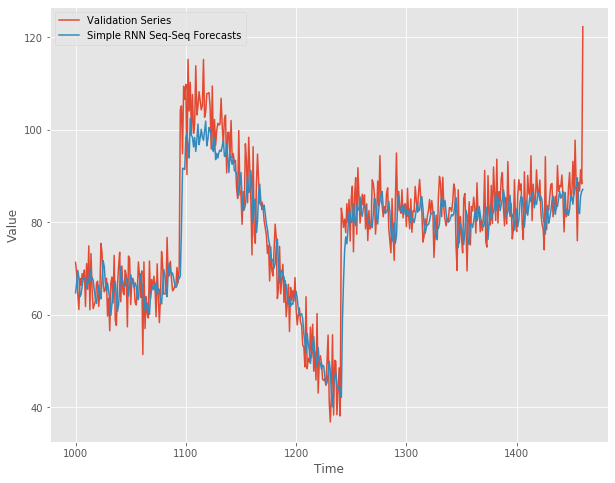

In [60]:
plt.figure(figsize=(10, 8))

plot_the_series(time_=time_valid, series_=x_valid, label="Validation Series")
plot_the_series(time_=time_valid, series_=seq_seq_rnn_forecasts_1D, label="Simple RNN Seq-Seq Forecasts")
plt.show()

In [61]:
seq_seq_rnn_forecasts_mae = tf.keras.metrics.mean_absolute_error(y_true=x_valid, y_pred=seq_seq_rnn_forecasts_1D).numpy()
seq_seq_rnn_forecasts_mae

5.1336284